패키지 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import os
import json

# 빠른 학습 중지와 모델 체크포인트를 위한 케라스 API를 사용하기 위해 불러옴.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

!pip install preprocess
from preprocess import *

시각화 함수 만들기 (학습 시각화)
 
 ==> 에폭당 정확도와 손실 값을 matplotlib을 통해 시각화하는 함수

In [2]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

학습 데이터 경로 설정 (코드 작성의 효율성 높임)

In [3]:
DATA_IN_PATH = '/content/drive/MyDrive/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
# 랜덤 시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
# 미리 전처리된 학습에 필요한 데이터 & 설정값 불러오기

In [6]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [7]:
# Show length
print(len(index_inputs), len(index_outputs), len(index_targets))

20 20 20


In [8]:
# 모델 구성에 필요한 값 선언
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2  #배치 크기
MAX_SEQUENCE = 25
EPOCH = 50  #에폭 횟수 (전체 학습 데이터를 전체 순화하는 것이 한 번, 즉 1번)
UNITS = 1024  #재귀 신경망의 결과 차원
EMBEDDING_DIM = 256  #임베딩 차원
VALIDATION_SPLIT = 0.1  #전체 데이터셋에서 평가셋의 크기 비율

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [10]:
# SEQ2SEQ 모델의 인코더

class Encoder(tf.keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
     # 인자 : batch_sz - 배치크기, enc_units - 재귀 신경망의 결과 차원, 
     #        vocab_size - 사전크기, embedding_dim - 임베딩 차원
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim) # 사전에 포함된 각 단어를 self.embedding_dim 차원의 임베딩 벡터로 만듬.
    self.gru = tf.keras.layers.GRU(self.enc_units, # self.enc_units : GRU의 결과 차원의 크기
                                   return_sequences=True, #각 시퀀스마다 출력을 반환할지 여부를 결정하는 값
                                   return_state=True, #마지막 상태 값의 반환 여부 (상태값 반환)
                                   recurrent_initializer='glorot_uniform') #초깃값을 무엇으로 할 것인지 선언
                                                      #Glorot 초기화 또는 Xavier 초기화 방법
                                                      # -> 이전 노드와 다음 노드의 개수에 의존하는 방법
  def call(self, x, hidden): #입력값x와 은닉상태 hidden을 받는다.
    x = self.embedding(x) #x값을 임베딩 벡터로 만든다.
    output, state = self.gru(x, initial_state = hidden)  
                #gru : 임베딩 벡터와 순환 신경망의 초기화 상태로 인자로 받은 은닉 상태를 전달
    return output, state  #시퀀스의 출력값 & 마지막 상태값 리턴

  def initialize_hidden_state(self, inp):  
      #배치 크기를 받아 순환 신경망에 초기에 사용될 크기의 은닉 상태를 만드는 역할을 함.
    return tf.zeros((tf.shape(inp)[0], self.enc_units)) 

문장이 길어질수록 더 많은 정보를 고정된 길이에 담아야 하므로 정보의 손실이 있음 / 순환망 특유의 문제인 장기 의존성 문제가 발생할 수 있는 부분 또한 문제점으로 지적됨.


==> 어텐션 방법으로 보완

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  #출력 크기가 units 크기인 W1, W2
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)  #출력 크기가 1인 V의 완전 연결계층

    def call(self, query, values):  # query : 인코더 순환 신경망의 은닉층의 상태 값 / values : 인코더 재귀 순환망의 결과값
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis))) # W1, W2의 결과값의 요소를 각각 더함.

        attention_weights = tf.nn.softmax(score, axis=1) #어텐션 가중치 -> 모델이 중요하다고 판단되는 값은 1에 가까워짐 / 영향도가 떨어질수록 0에 가까운 값.

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [13]:
# 디코더

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x) #임베딩 벡터를 받고 문맥 벡터와 임베딩 벡터를 결합해 x를 구성하고,
                              #디코더 순환 신경망을 통해서 순환 신경망의 결과값을 얻게되고,
                              #이 값을 완전 연결 게층(fully-connected layer)을 통과해서 사전 크기의 벡터 x를 만든다.

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

손실 함수 & 정확도 측정 함수 

In [15]:
optimizer = tf.keras.optimizers.Adam()  #아담을 사용하기 위한 객체(optimizer) -> 최적화로 사용

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  #크로스 엔트로피로 손실 값을 측정하기 위한 객체

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')  #정확도 측정을 하기 위한 객체

def loss(real, pred):  #인자로 정답과 예측한 값을 받아서 두 개의 값을 비교해서 손실을 계산 / real값 중 0인 값 <PAD>는 손실 게산에서 빼기 위한 함수
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #정답 real에 포함되는 값 중 0인 것은 <PAD>를 의미하는 값. (True(1)가 되고 <PAD>를 제외한 나머지값들은 False(0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):  #loss함수와 비슷함. 하지만 다른 점 : train_accuracy 함수를 통해 정확도를 체크해야한다는 것.
    mask = tf.math.logical_not(tf.math.equal(real, 0))  #logical_not 함수 : 각 요소들의 값은 0->1, 1->0으로 변경
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

각 클래스를 이어주는 메인 seq2seq 클래스

In [17]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)  #self.encoder => 인코더의 결과값과 인코더 은닉 상태값을 만든다.
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)  #디코더 => 시퀀스 최대 길이만큼 반복하면서 디코더 출력값을 만들어낸다.

    def call(self, x): #인코더의 입력값 & 디코더의 입력값을 x를 통해 받는다. 
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()  #시퀀스마다 나온 결과값을 넣음. / 손실 계산 or 정확도 계산하는 용도로 사용
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):  #사용자 입력에 대한 모델의 결괏값을 확인하게 위해 테스트 목적으로 만들어진 함수
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

seq2seq 객체 생성 / compile함수를 통해 학습 방식 설정(손실함수, 최적화 함수, 성능 측정 함수)

In [18]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

학습 진행

In [19]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.9257 - accuracy: 0.8360
Epoch 00001: val_accuracy improved from -inf to 0.85400, saving model to /content/drive/MyDrive/data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 80s 4s/step - loss: 0.9257 - accuracy: 0.8360 - val_loss: 0.7055 - val_accuracy: 0.8540
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.8527
Epoch 00002: val_accuracy improved from 0.85400 to 0.85600, saving model to /content/drive/MyDrive/data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 26s 3s/step - loss: 0.7924 - accuracy: 0.8527 - val_loss: 0.6086 - val_accuracy: 0.8560
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.8572
Epoch 00003: val_accuracy improved from 0.85600 to 0.85667, saving model to /content/drive/MyDrive/data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 26s 3s/step - loss: 0.6811 - accuracy: 0.

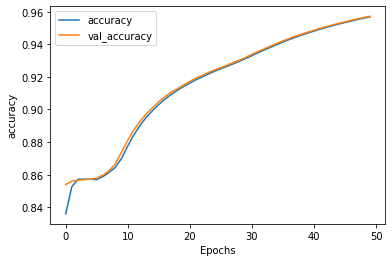

In [20]:
plot_graphs(history, 'accuracy')

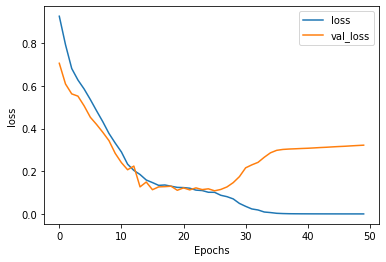

In [21]:
plot_graphs(history, 'loss')

In [22]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [27]:
FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"  #어떤 의미도 없는 패딩 토큰
STD = "<SOS>"  #시작 토큰을 의미
END = "<END>"  #종료 토큰을 의미
UNK = "<UNK>"  #사전에 없는 단어를 의미
PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25

In [24]:
def enc_processing(value, dictionary, tokenize_as_morph=False):   #value:전처리할 데이터 / dictionary:단어 사전
    # 인덱스 값들을 가지고 있는 배열. (누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의 길이를 가지고 있다. (누적된다.)
    sequences_length = []

    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    # 한줄씩 불어온다.
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence) #정규 표현식을 통해 특수문자 제거 (필터에 들어있는 값들을 ""으로 치환)
        sequence_index = [] #문장을 스페이스 단위로 자르고 있다.
        for word in sequence.split(): #잘려진 단어들이 딕셔너리에 존재하는지 보고 그 값을 가져와 sequence.index에 추가
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])  #단어 사전을 이용해 단어 인덱스로 바꿈.
            else:
                sequence_index.extend([dictionary[UNK]])  #어떤 단어가 단어 사전에 포함되어있지 않다면 UNK 토큰을 넣는다.

        #문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        #하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가 작다면 빈 부분에 PAD(0)을 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을 sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)

    # 인덱스화된 일반 배열을 넘파이 배열로 변경
    # -> 텐서플로우 dataset에 넣어 주기 위한 사전 작업
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_input_index), sequences_length


In [28]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[65 98 45 70 20  5]
평소에 필요했던 게 좋을 것 같아요
